# Helmholtz 1D: Coarsening Operator Quality vs. TV Smoothing
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size to $4$ points. Consider a certain aggregate in the domain (say, the first one).
* Observe beahviour vs. $\nu$:
  * Create relaxed TVs with $\nu$ Kaczmarz relaxation sweeps.
  * Create the coarsening operator $R$ using SVD. Observe singular value decay rate.
  * Observe two-level mini-cycle convergence factor before slowing down.

In [45]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Number of test vectors.
num_examples = 10
threshold = 0.1
kh = 0.5

nu  5 s [1.    0.374 0.241 0.055] Energy error [0.409 0.225 0.05  0.   ]
nu 10 s [1.    0.289 0.115 0.02 ] Energy error [0.298 0.112 0.019 0.   ]
nu 20 s [1.    0.297 0.061 0.006] Energy error [0.29  0.059 0.006 0.   ]
nu 40 s [1.    0.327 0.055 0.003] Energy error [0.314 0.052 0.003 0.   ]
nu 80 s [1.    0.382 0.049 0.002] Energy error [0.359 0.046 0.002 0.   ]


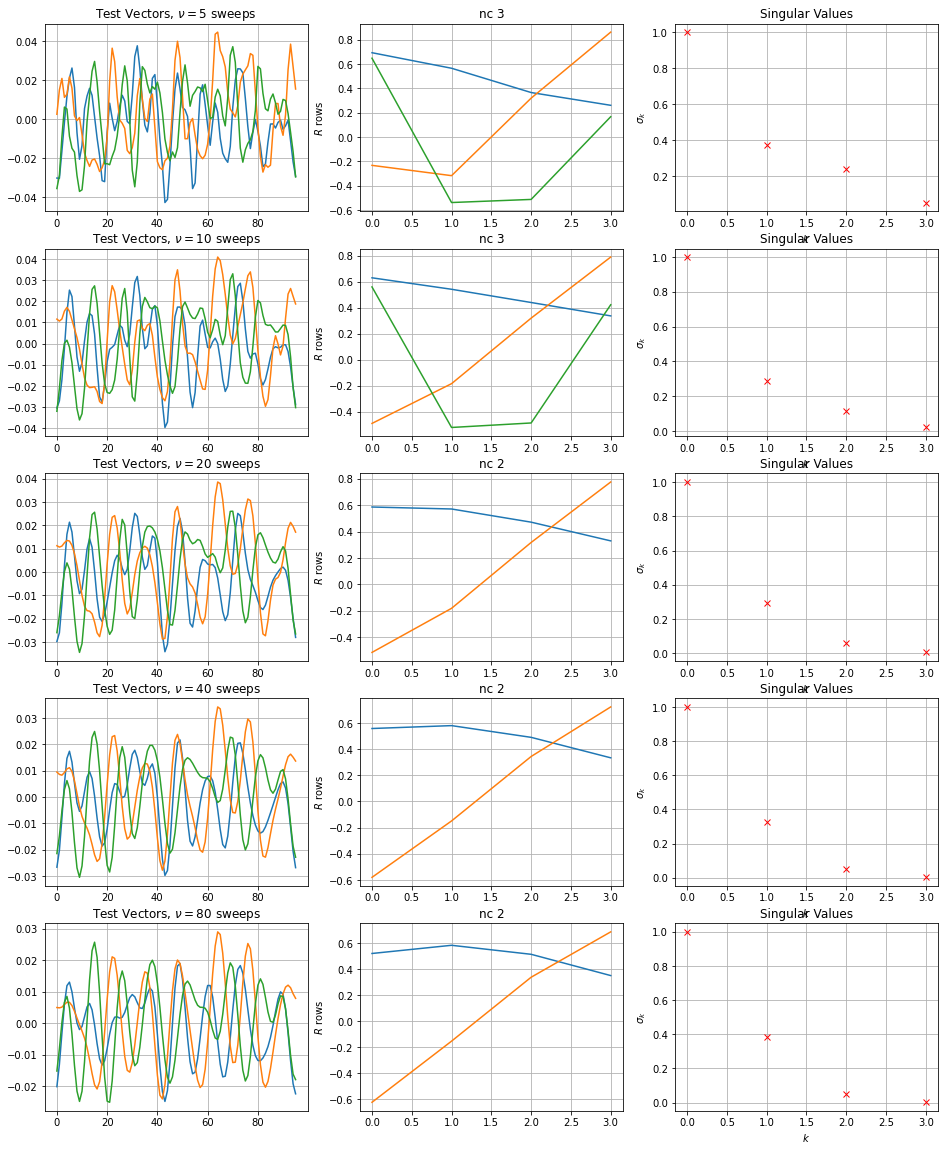

In [50]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)
x_random = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
b = np.zeros_like(x_random)

aggregate_size = 4
num_sweeps_values = 5 * 2 ** np.arange(5)

fig, axs = plt.subplots(len(num_sweeps_values), 3, figsize=(16, 4 * len(num_sweeps_values)))
for row, num_sweeps in enumerate(num_sweeps_values):
    # Create relaxed TVs.
    x = hm.solve.run.run_iterative_method(
        level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]

    start, end = 0, aggregate_size
    x_aggregate_t = x[start:end].transpose()
    r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # # Create coarsening operator R.
    # r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_full_domain(
    #     x, threshold=threshold)
    # print(r.shape)
    # logger.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
    # logger.info("nc  {}".format(nc))
    # logger.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title("nc {}".format(r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("nu", "{:2d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

Here it is not clear if there are any strong correlations. So how come relaxation converges so slowly? Shouldn't Gauss-Seidel be fast in this case?

## Smoothing Factor
Given an iterative method,
* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate the Residual to Error Ratio (RER) $r_i := \|A x_i\|_2 / \|x_i\|_2$ and the RER reduction factor per sweep, $c_i := r_i / r_{i-1}$, $i = 1, 2, \dots$. * Average $c_i$ over the $5$ starts.
* Terminate the method after $n_{max}$ sweeps are reached, or $\mu_i > \mu_{max}$ (we use $n_{max} = 20, \mu_{max} = 1.1$).
* Fit a piecewise constant/power-law-with-intercept model in least-squares sesnse:
$$ c(n) = \mu_0, \qquad n \leq n_0\,, $$
$$ c(n) = \mu_{\infty} - (\mu_{\infty} - \mu_0) (\frac{n}{n_0})^p, \qquad n \geq n_0\,. $$
* The model depends on the parameters $\mu_0, n_0, \mu_{\infty}, p$. The **smoothing factor** is defined as $\mu_0$, the initial constant RER reduction, which is sustained for $n_0$ sweeps. Then the convegence is overtaken by smooth components; the asymptotic convergence factor estimate is $\mu_{\infty}$, and the power-law rate of reaching it is $p$ (which is negative).

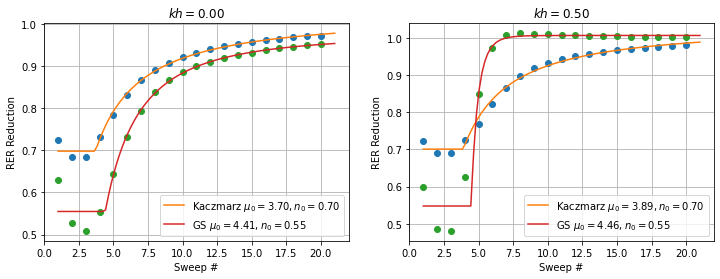

In [217]:
kh_values = [0, 0.5]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)

# Kaczmarz.
for kh, ax in zip(kh_values, axs):
    a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
    operator = lambda x: a.dot(x)

    for title, relax in zip(("Kaczmarz", "GS"), (kaczmarz, gs)):
        p, conv = hm.solve.smoothing.shrinkage_factor(
            operator, relax(a), (n, ), print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
        hm.solve.smoothing.plot_fitted_conv_model(p, conv, ax, title=title)

    ax.set_title(r"$kh = {:.2f}$".format(kh))
    ax.legend()

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes, showing that GS is a better smoother for $kh = 0, 0.5$ but slightly diverges for $kh = 0.5$.